In [59]:
import h5py
import yaml
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np

from utils import FluidDataset
from unet2 import UNet
from denoising_diffusion import DenoisingDiffusion

In [127]:
train_dataset = FluidDataset(root='/media/bamf-big/gefan/DiffFluids/data/2d_floating_smoke/', name='NSPointSrcSmoke_resolution_64x64_train.h5')
test_dataset = FluidDataset(root='/media/bamf-big/gefan/DiffFluids/data/2d_floating_smoke/', name='NSPointSrcSmoke_resolution_64x64_test.h5')

Loaded 4800 samples from NSPointSrcSmoke_resolution_64x64_train.h5 in /media/bamf-big/gefan/DiffFluids/data/2d_floating_smoke/.
Loaded 1200 samples from NSPointSrcSmoke_resolution_64x64_test.h5 in /media/bamf-big/gefan/DiffFluids/data/2d_floating_smoke/.


In [3]:
def get_time(t: float, n_samples: int, resolution: tuple=(64, 64), max_time: float=50.0):
    t = t / max_time * torch.ones(n_samples, 1, *resolution)
    return t

In [4]:
with open('/media/bamf-big/gefan/DiffFluids/diff_fluids/ddpm/config.yaml') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)
    eps_model = UNet(**configs['eps_model'])
    eps_model.load_state_dict(torch.load('./checkpoint/smoke64x64_t+src2rho+vel.pth'))
    diffuser = DenoisingDiffusion(
        eps_model=eps_model,
        **configs['diffuser']
    ).cuda(1)

### Reproducing the trainning dataset

In [105]:
pos_indexs = [24]
time_indexs = [0, 20, 30, 50, 70, 90]

In [106]:
u0, v0, y0 = [], [], []
for p_i in pos_indexs:
    for t_i in time_indexs:
        u0.append(train_dataset[p_i*100+t_i]['u'])
        v0.append(train_dataset[p_i*100+t_i]['v'])
        y0.append(train_dataset[p_i*100+t_i]['y'])
u0 = torch.stack(u0)
v0 = torch.stack(v0)
y0 = torch.stack(y0)

In [107]:
x_pred = diffuser.sample(torch.randn_like(torch.cat((u0, v0), dim=1)).cuda(1), y0.cuda(1))

100%|██████████| 500/500 [00:22<00:00, 22.20it/s]


In [108]:
x_pred = x_pred.detach().cpu()
u_pred, vx_pred, vy_pred = torch.chunk(x_pred, 3, dim=1)
vx0, vy0 = torch.chunk(v0, 2, dim=1)
u_pred, vx_pred, vy_pred, u0, vx0, vy0 = map(lambda x: x.squeeze(), (u_pred, vx_pred, vy_pred, u0, vx0, vy0))

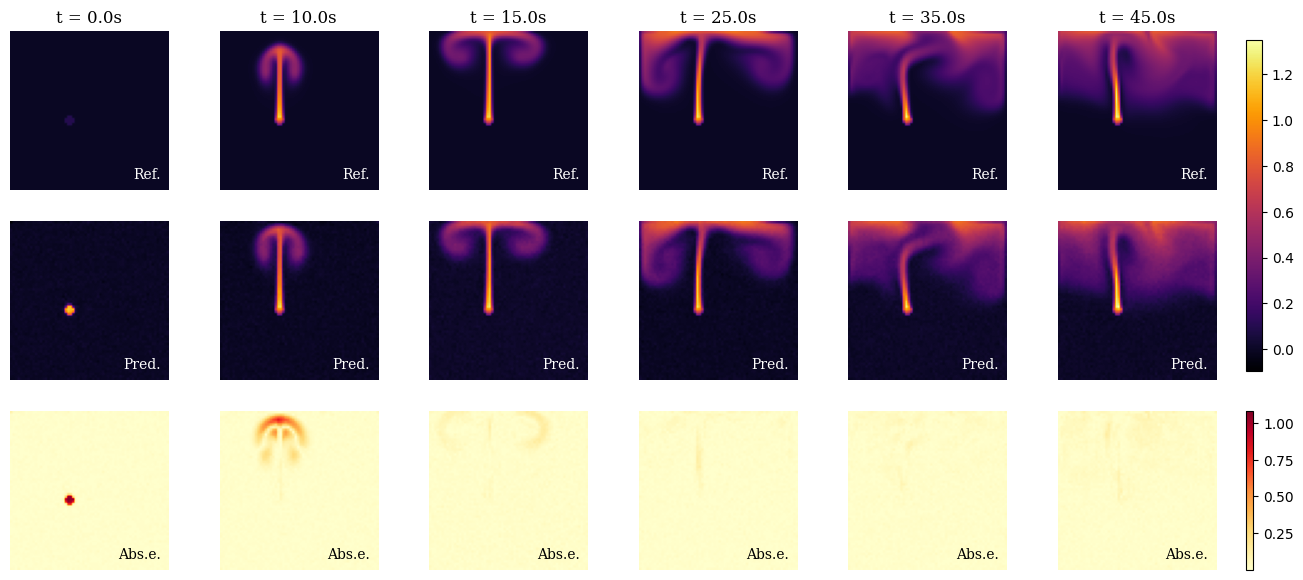

In [76]:
norm1 = colors.Normalize(vmin=min(u0.min(), u_pred.min()), vmax=max(u0.max(), u_pred.max()))
error = torch.abs(u_pred - u0)
norm2 = colors.Normalize(vmin=error.min(), vmax=error.max())

cmap1 = 'inferno'
cmap2 = 'YlOrRd'
fig, ax = plt.subplots(3, 6, figsize=(19, 7))
for i in range(6):
    im1 = ax[0, i].imshow(u0[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[0, i].axis('off')
    ax[0, i].set_title(f"t = {time_indexs[i]*0.5:.1f}s", fontfamily='serif', fontsize=12)
    ax[0, i].text(0.95, 0.05, 'Ref.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[0, i].transAxes)
    ax[1, i].imshow(u_pred[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[1, i].axis('off')
    ax[1, i].text(0.95, 0.05, 'Pred.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[1, i].transAxes)
    im2 = ax[2, i].imshow(torch.abs(error[i]), norm=norm2, cmap=cmap2, origin='lower')
    ax[2, i].axis('off')
    ax[2, i].text(0.95, 0.05, 'Abs.e.', ha='right', va='bottom', color='black', fontfamily='serif', fontsize=10, transform=ax[2, i].transAxes)
cbar1 = fig.colorbar(im1, ax=ax[:2], shrink=0.95, pad=0.02)
cbar2 = fig.colorbar(im2, ax=ax[2], shrink=1.0, pad=0.02)
fig.savefig('/media/bamf-big/gefan/DiffFluids/assets/predict_rho.png', dpi=150, bbox_inches='tight')

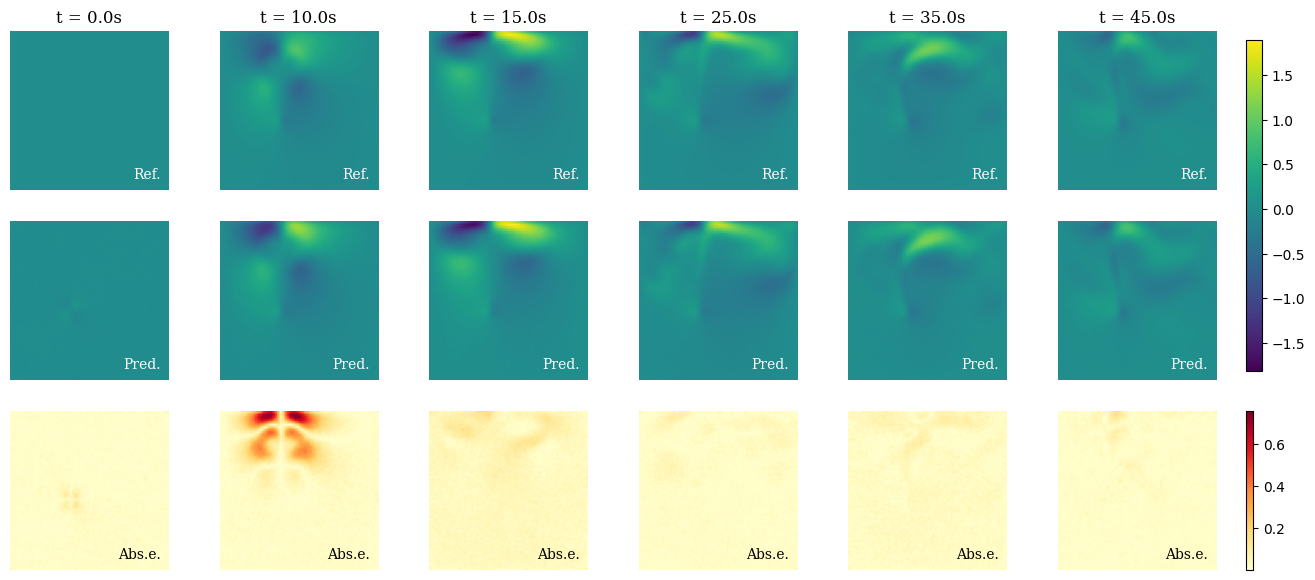

In [74]:
norm1 = colors.Normalize(vmin=min(vx0.min(), vx_pred.min()), vmax=max(vx0.max(), vx_pred.max()))
error = torch.abs(vx_pred - vx0)
norm2 = colors.Normalize(vmin=error.min(), vmax=error.max())

cmap1 = 'viridis'
cmap2 = 'YlOrRd'
fig, ax = plt.subplots(3, 6, figsize=(19, 7))
for i in range(6):
    im1 = ax[0, i].imshow(vx0[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[0, i].axis('off')
    ax[0, i].set_title(f"t = {time_indexs[i]*0.5:.1f}s", fontfamily='serif', fontsize=12)
    ax[0, i].text(0.95, 0.05, 'Ref.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[0, i].transAxes)
    ax[1, i].imshow(vx_pred[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[1, i].axis('off')
    ax[1, i].text(0.95, 0.05, 'Pred.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[1, i].transAxes)
    im2 = ax[2, i].imshow(error[i], norm=norm2, cmap=cmap2, origin='lower')
    ax[2, i].axis('off')
    ax[2, i].text(0.95, 0.05, 'Abs.e.', ha='right', va='bottom', color='black', fontfamily='serif', fontsize=10, transform=ax[2, i].transAxes)
cbar1 = fig.colorbar(im1, ax=ax[:2], shrink=0.95, pad=0.02)
cbar2 = fig.colorbar(im2, ax=ax[2], shrink=1.0, pad=0.02)
fig.savefig('/media/bamf-big/gefan/DiffFluids/assets/predict_vx.png', dpi=150, bbox_inches='tight')

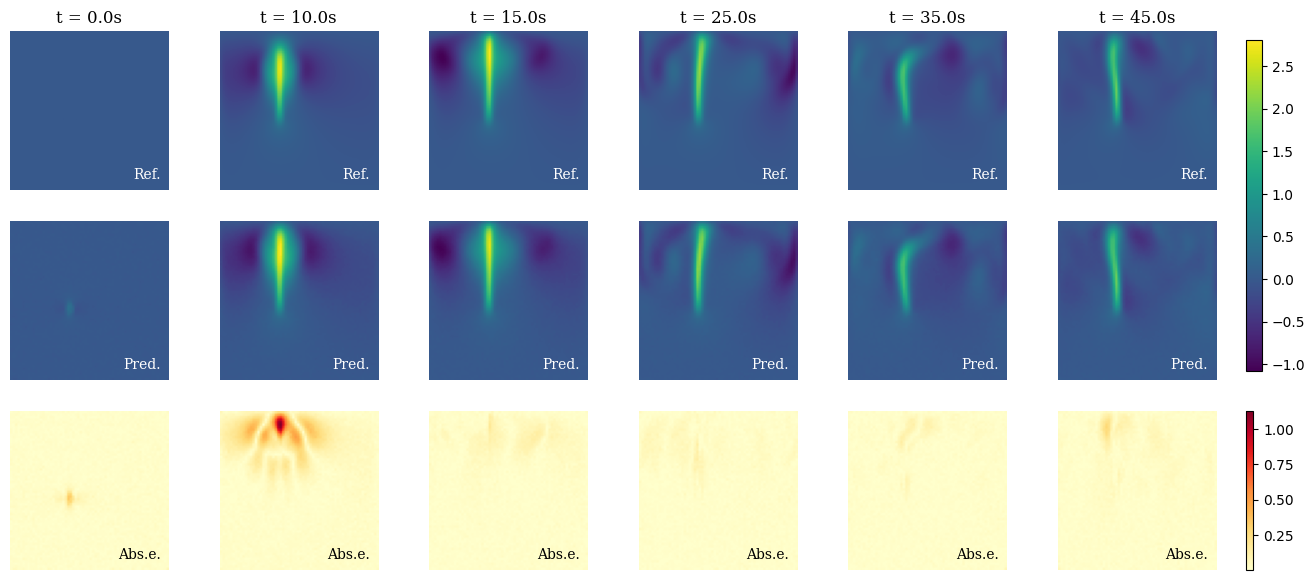

In [75]:
norm1 = colors.Normalize(vmin=min(vy0.min(), vy_pred.min()), vmax=max(vy0.max(), vy_pred.max()))
error = torch.abs(vy_pred - vy0)
norm2 = colors.Normalize(vmin=error.min(), vmax=error.max())

cmap1 = 'viridis'
cmap2 = 'YlOrRd'
fig, ax = plt.subplots(3, 6, figsize=(19, 7))
for i in range(6):
    im1 = ax[0, i].imshow(vy0[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[0, i].axis('off')
    ax[0, i].set_title(f"t = {time_indexs[i]*0.5:.1f}s", fontfamily='serif', fontsize=12)
    ax[0, i].text(0.95, 0.05, 'Ref.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[0, i].transAxes)
    ax[1, i].imshow(vy_pred[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[1, i].axis('off')
    ax[1, i].text(0.95, 0.05, 'Pred.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[1, i].transAxes)
    im2 = ax[2, i].imshow(error[i], norm=norm2, cmap=cmap2, origin='lower')
    ax[2, i].axis('off')
    ax[2, i].text(0.95, 0.05, 'Abs.e.', ha='right', va='bottom', color='black', fontfamily='serif', fontsize=10, transform=ax[2, i].transAxes)
cbar1 = fig.colorbar(im1, ax=ax[:2], shrink=0.95, pad=0.02)
cbar2 = fig.colorbar(im2, ax=ax[2], shrink=1.0, pad=0.02)
fig.savefig('/media/bamf-big/gefan/DiffFluids/assets/predict_vy.png', dpi=150, bbox_inches='tight')

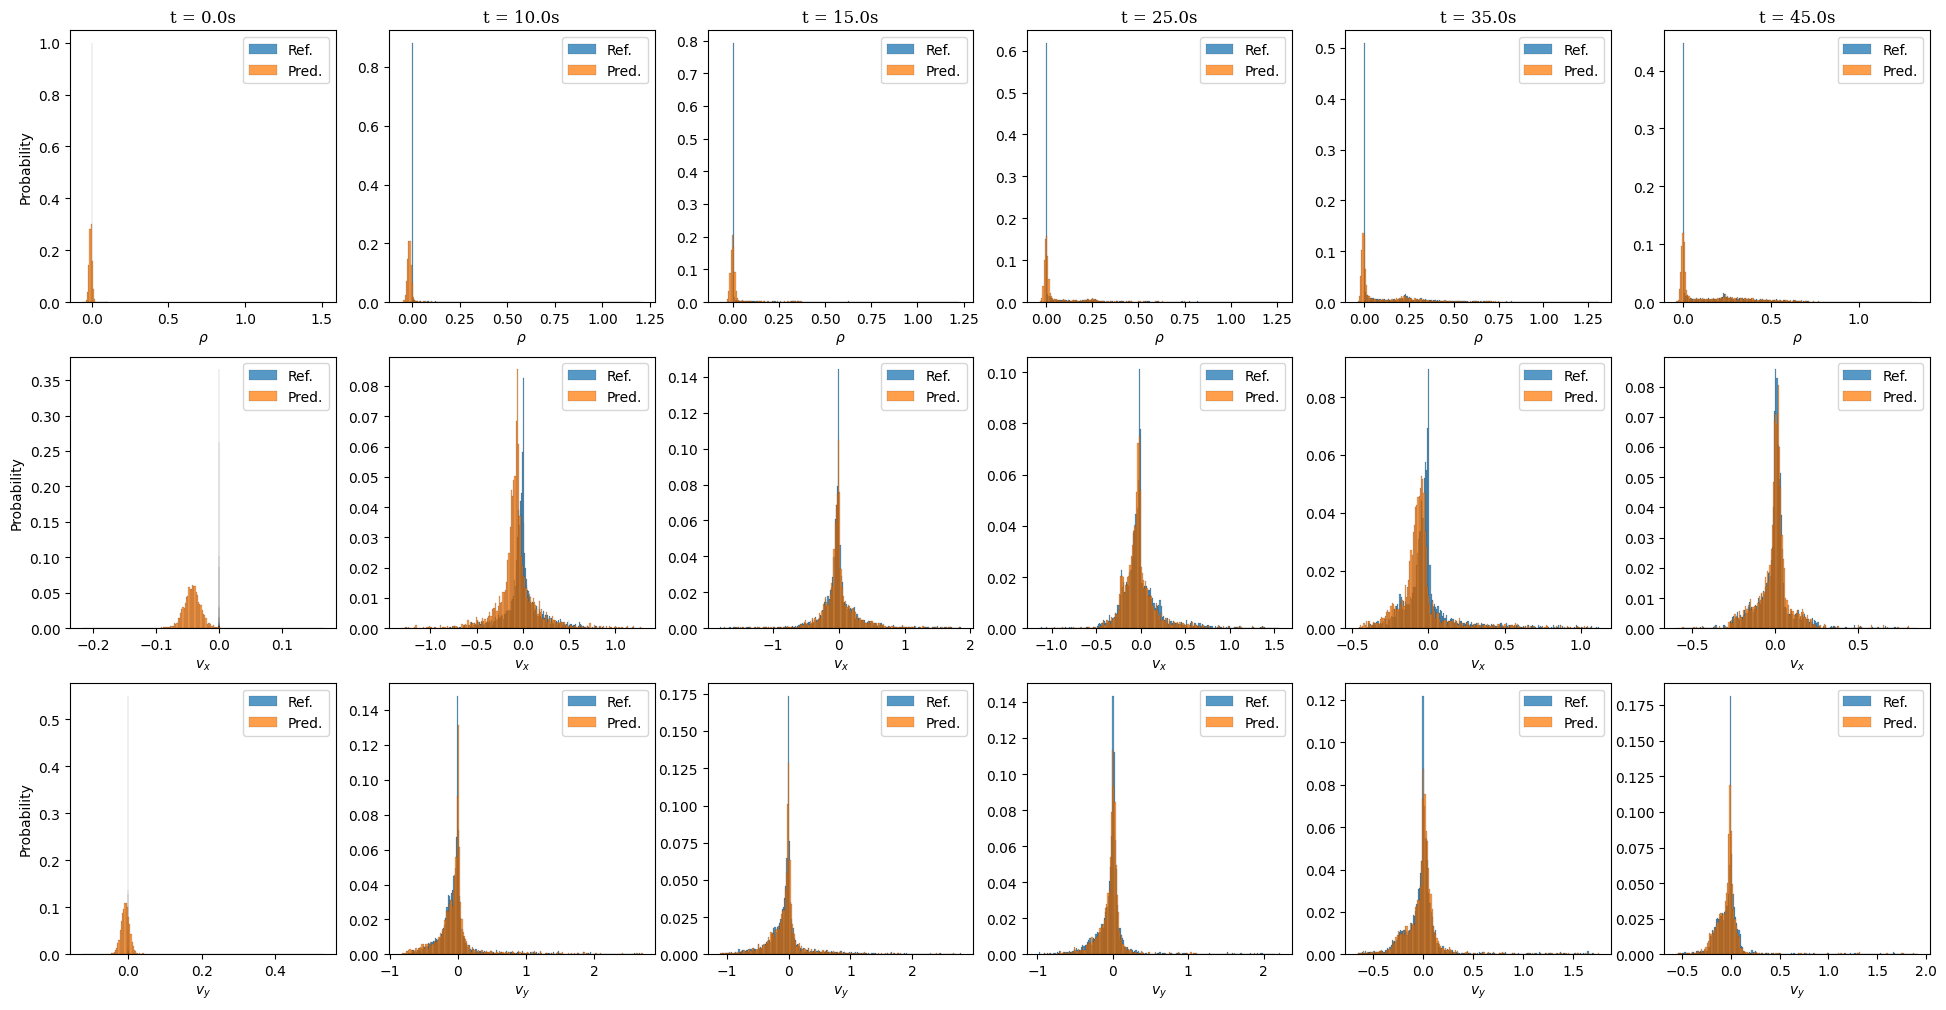

In [112]:
fig, ax = plt.subplots(3, 6, figsize=(24, 12))
for i in range(6):
    sns.histplot(u0[i].flatten(), ax=ax[0, i], bins=200, stat='probability', label='Ref.')
    sns.histplot(u_pred[i].flatten(), ax=ax[0, i], bins=200, stat='probability', label='Pred.')
    ax[0, i].set_title(f"t = {time_indexs[i]*0.5:.1f}s", fontfamily='serif', fontsize=12)
    ax[0, i].set_xlabel(r'$\rho$')
    ax[0, i].legend()
    sns.histplot(vx0[i].flatten(), ax=ax[1, i], bins=200, stat='probability', label='Ref.')
    sns.histplot(vx_pred[i].flatten(), ax=ax[1, i], bins=200, stat='probability', label='Pred.')
    ax[1, i].set_xlabel(r'$v_x$')
    ax[1, i].legend()
    sns.histplot(vy0[i].flatten(), ax=ax[2, i], bins=200, stat='probability', label='Ref.')
    sns.histplot(vy_pred[i].flatten(), ax=ax[2, i], bins=200, stat='probability', label='Pred.')
    ax[2, i].set_xlabel(r'$v_y$')
    ax[2, i].legend()
    if i != 0:
        ax[0, i].set_ylabel('')
        ax[1, i].set_ylabel('')
        ax[2, i].set_ylabel('')

In [113]:
fig.savefig('/media/bamf-big/gefan/DiffFluids/assets/predict_hist.png', dpi=150, bbox_inches='tight')

### Interpolation

In [149]:
# src pos (14.0, 2.5)
pos_indexs = [5]
ts = [45.0, 45.25, 45.75, 46.25, 46.75, 47.0]
time_indexs = [180, 181, 183, 185, 187, 188]

In [150]:
u0, v0, y0 = [], [], []
for p_i in pos_indexs:
    for t_i in time_indexs:
        u0.append(test_dataset[p_i*100+t_i]['u'])
        v0.append(test_dataset[p_i*100+t_i]['v'])
        y0.append(test_dataset[p_i*100+t_i]['y'])
u0 = torch.stack(u0)
v0 = torch.stack(v0)
y0 = torch.stack(y0)

In [151]:
x_pred = diffuser.sample(torch.randn_like(torch.cat((u0, v0), dim=1)).cuda(1), y0.cuda(1))

100%|██████████| 500/500 [00:22<00:00, 22.12it/s]


In [152]:
x_pred = x_pred.detach().cpu()
u_pred, vx_pred, vy_pred = torch.chunk(x_pred, 3, dim=1)
vx0, vy0 = torch.chunk(v0, 2, dim=1)
u_pred, vx_pred, vy_pred, u0, vx0, vy0 = map(lambda x: x.squeeze(), (u_pred, vx_pred, vy_pred, u0, vx0, vy0))

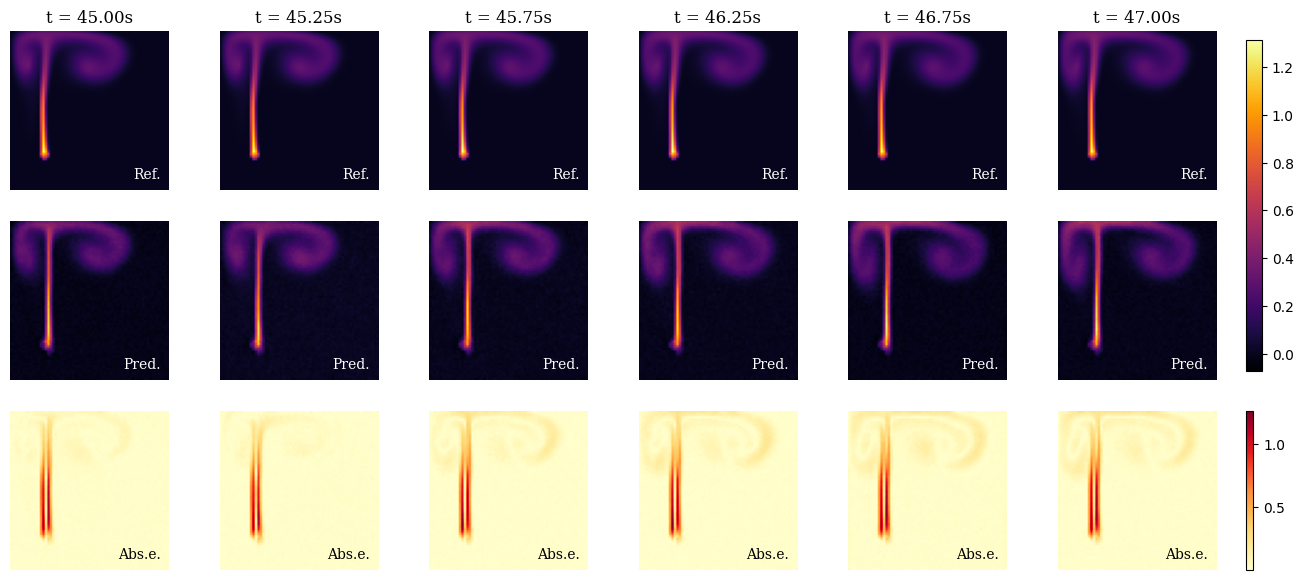

In [154]:
norm1 = colors.Normalize(vmin=min(u0.min(), u_pred.min()), vmax=max(u0.max(), u_pred.max()))
error = torch.abs(u_pred - u0)
norm2 = colors.Normalize(vmin=error.min(), vmax=error.max())

cmap1 = 'inferno'
cmap2 = 'YlOrRd'
fig, ax = plt.subplots(3, 6, figsize=(19, 7))
for i in range(6):
    im1 = ax[0, i].imshow(u0[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[0, i].axis('off')
    ax[0, i].set_title(f"t = {ts[i]:.2f}s", fontfamily='serif', fontsize=12)
    ax[0, i].text(0.95, 0.05, 'Ref.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[0, i].transAxes)
    ax[1, i].imshow(u_pred[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[1, i].axis('off')
    ax[1, i].text(0.95, 0.05, 'Pred.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[1, i].transAxes)
    im2 = ax[2, i].imshow(torch.abs(error[i]), norm=norm2, cmap=cmap2, origin='lower')
    ax[2, i].axis('off')
    ax[2, i].text(0.95, 0.05, 'Abs.e.', ha='right', va='bottom', color='black', fontfamily='serif', fontsize=10, transform=ax[2, i].transAxes)
cbar1 = fig.colorbar(im1, ax=ax[:2], shrink=0.95, pad=0.02)
cbar2 = fig.colorbar(im2, ax=ax[2], shrink=1.0, pad=0.02)
fig.savefig('/media/bamf-big/gefan/DiffFluids/assets/interpolate_rho.png', dpi=150, bbox_inches='tight')

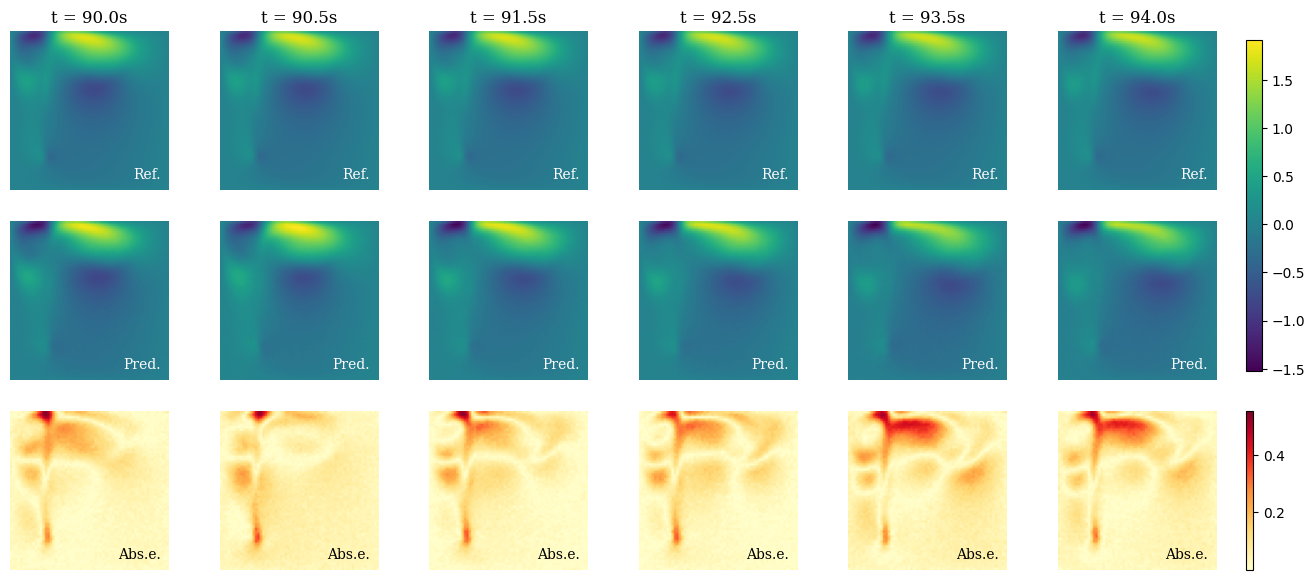

In [155]:
norm1 = colors.Normalize(vmin=min(vx0.min(), vx_pred.min()), vmax=max(vx0.max(), vx_pred.max()))
error = torch.abs(vx_pred - vx0)
norm2 = colors.Normalize(vmin=error.min(), vmax=error.max())

cmap1 = 'viridis'
cmap2 = 'YlOrRd'
fig, ax = plt.subplots(3, 6, figsize=(19, 7))
for i in range(6):
    im1 = ax[0, i].imshow(vx0[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[0, i].axis('off')
    ax[0, i].set_title(f"t = {time_indexs[i]*0.5:.1f}s", fontfamily='serif', fontsize=12)
    ax[0, i].text(0.95, 0.05, 'Ref.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[0, i].transAxes)
    ax[1, i].imshow(vx_pred[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[1, i].axis('off')
    ax[1, i].text(0.95, 0.05, 'Pred.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[1, i].transAxes)
    im2 = ax[2, i].imshow(error[i], norm=norm2, cmap=cmap2, origin='lower')
    ax[2, i].axis('off')
    ax[2, i].text(0.95, 0.05, 'Abs.e.', ha='right', va='bottom', color='black', fontfamily='serif', fontsize=10, transform=ax[2, i].transAxes)
cbar1 = fig.colorbar(im1, ax=ax[:2], shrink=0.95, pad=0.02)
cbar2 = fig.colorbar(im2, ax=ax[2], shrink=1.0, pad=0.02)
fig.savefig('/media/bamf-big/gefan/DiffFluids/assets/interpolate_vx.png', dpi=150, bbox_inches='tight')

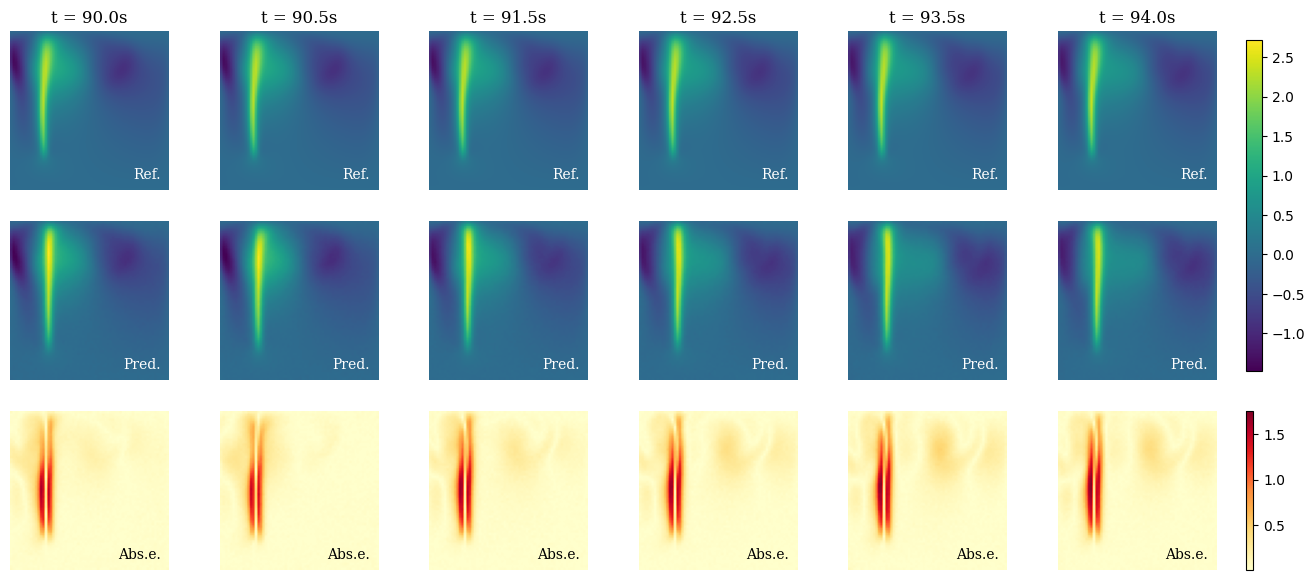

In [156]:
norm1 = colors.Normalize(vmin=min(vy0.min(), vy_pred.min()), vmax=max(vy0.max(), vy_pred.max()))
error = torch.abs(vy_pred - vy0)
norm2 = colors.Normalize(vmin=error.min(), vmax=error.max())

cmap1 = 'viridis'
cmap2 = 'YlOrRd'
fig, ax = plt.subplots(3, 6, figsize=(19, 7))
for i in range(6):
    im1 = ax[0, i].imshow(vy0[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[0, i].axis('off')
    ax[0, i].set_title(f"t = {time_indexs[i]*0.5:.1f}s", fontfamily='serif', fontsize=12)
    ax[0, i].text(0.95, 0.05, 'Ref.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[0, i].transAxes)
    ax[1, i].imshow(vy_pred[i], cmap=cmap1, norm=norm1, origin='lower')
    ax[1, i].axis('off')
    ax[1, i].text(0.95, 0.05, 'Pred.', ha='right', va='bottom', color='white', fontfamily='serif', fontsize=10, transform=ax[1, i].transAxes)
    im2 = ax[2, i].imshow(error[i], norm=norm2, cmap=cmap2, origin='lower')
    ax[2, i].axis('off')
    ax[2, i].text(0.95, 0.05, 'Abs.e.', ha='right', va='bottom', color='black', fontfamily='serif', fontsize=10, transform=ax[2, i].transAxes)
cbar1 = fig.colorbar(im1, ax=ax[:2], shrink=0.95, pad=0.02)
cbar2 = fig.colorbar(im2, ax=ax[2], shrink=1.0, pad=0.02)
fig.savefig('/media/bamf-big/gefan/DiffFluids/assets/interpolate_vy.png', dpi=150, bbox_inches='tight')

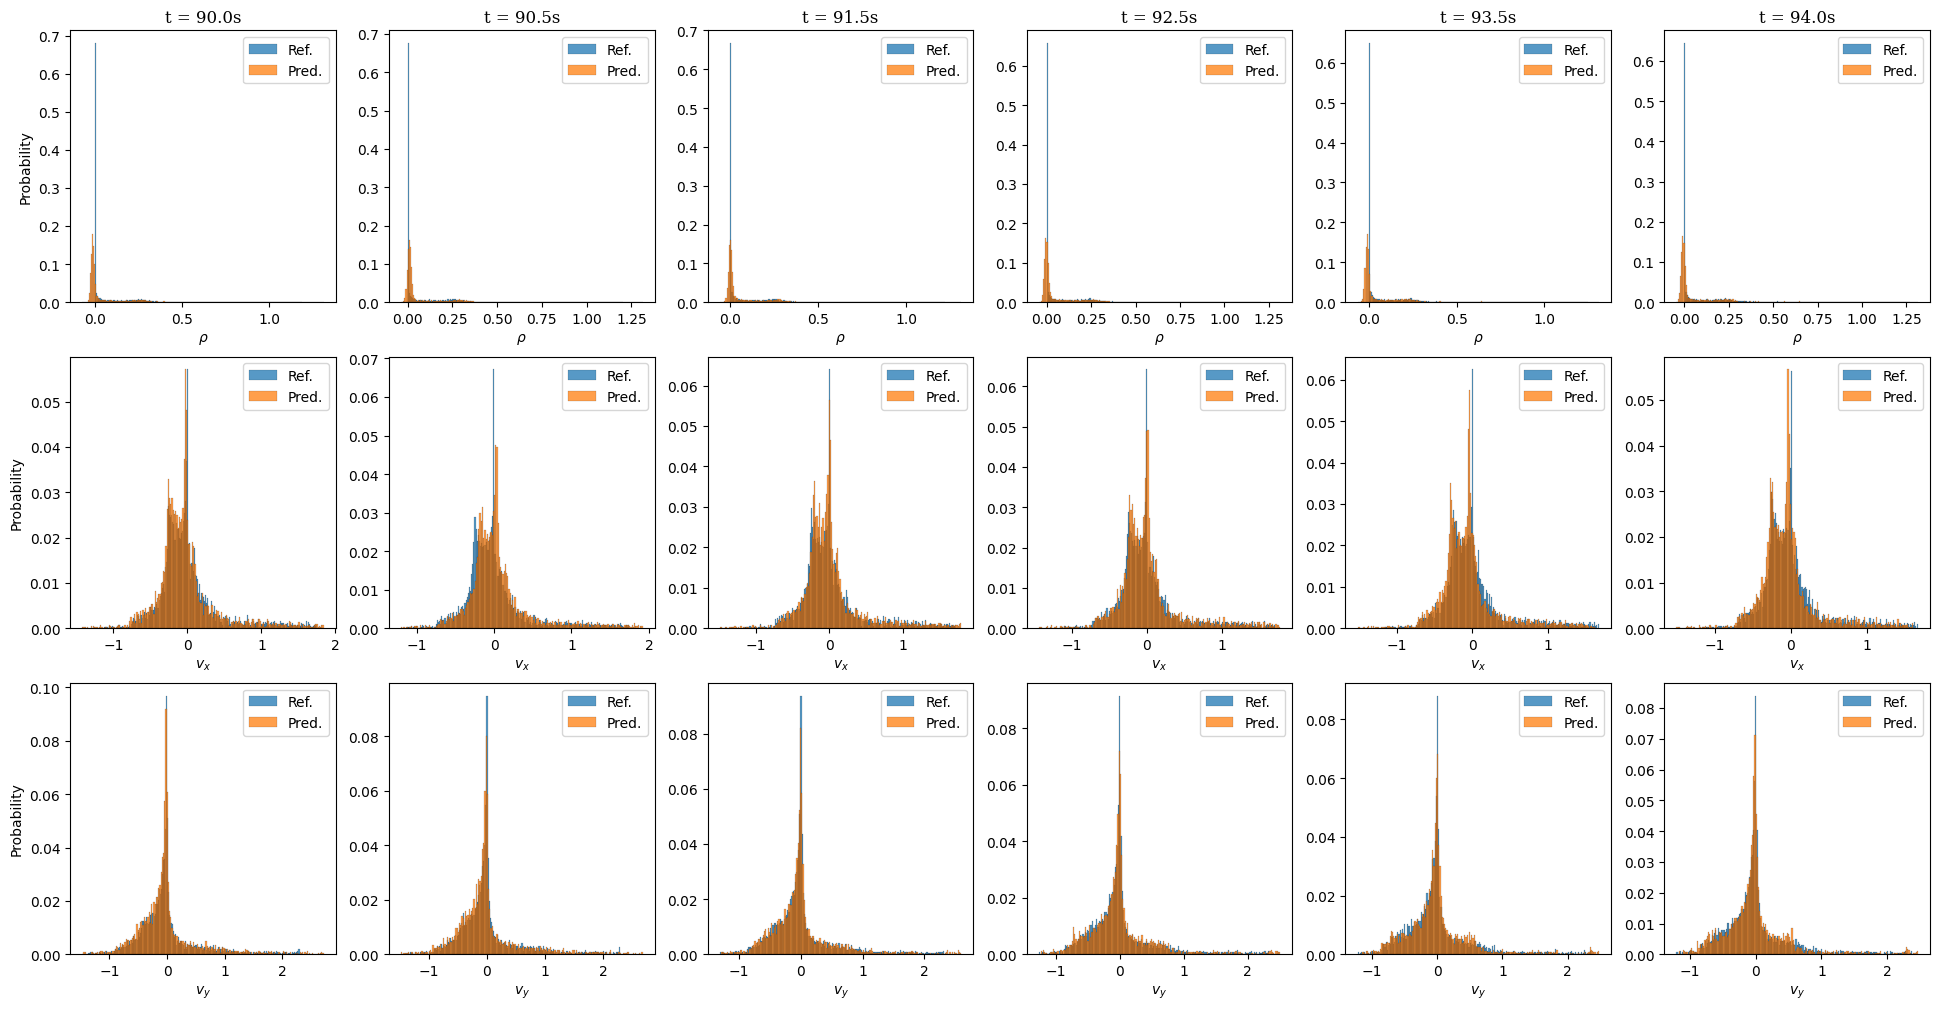

In [157]:
fig, ax = plt.subplots(3, 6, figsize=(24, 12))
for i in range(6):
    sns.histplot(u0[i].flatten(), ax=ax[0, i], bins=200, stat='probability', label='Ref.')
    sns.histplot(u_pred[i].flatten(), ax=ax[0, i], bins=200, stat='probability', label='Pred.')
    ax[0, i].set_title(f"t = {time_indexs[i]*0.5:.1f}s", fontfamily='serif', fontsize=12)
    ax[0, i].set_xlabel(r'$\rho$')
    ax[0, i].legend()
    sns.histplot(vx0[i].flatten(), ax=ax[1, i], bins=200, stat='probability', label='Ref.')
    sns.histplot(vx_pred[i].flatten(), ax=ax[1, i], bins=200, stat='probability', label='Pred.')
    ax[1, i].set_xlabel(r'$v_x$')
    ax[1, i].legend()
    sns.histplot(vy0[i].flatten(), ax=ax[2, i], bins=200, stat='probability', label='Ref.')
    sns.histplot(vy_pred[i].flatten(), ax=ax[2, i], bins=200, stat='probability', label='Pred.')
    ax[2, i].set_xlabel(r'$v_y$')
    ax[2, i].legend()
    if i != 0:
        ax[0, i].set_ylabel('')
        ax[1, i].set_ylabel('')
        ax[2, i].set_ylabel('')

In [158]:
fig.savefig('/media/bamf-big/gefan/DiffFluids/assets/interpolate_hist.png', dpi=150, bbox_inches='tight')